# Temperature forecasting

In [6]:
import numpy as np
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd 
from dataclasses import dataclass

In [7]:
TEMPERATURES_CSV = '../data/daily-min-temperatures.csv'
df = pd.read_csv(TEMPERATURES_CSV)
df.head() # 81-90 10 years temperature data
# df.shape # (3650, 2)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [8]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
               
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        
        i = 0
        for row in reader:
            temperatures.append(float(row[1]))
            times.append(i)
            i +=1
            
    return times, temperatures


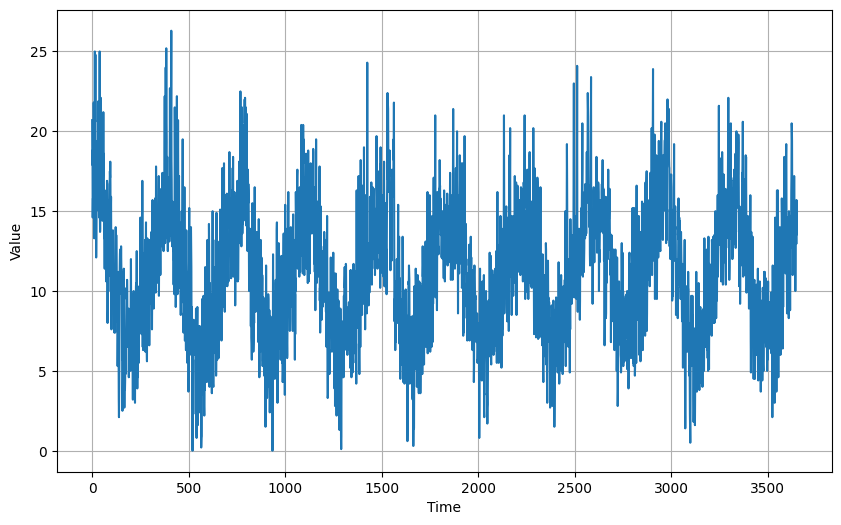

In [10]:
# 
TEMPERATURES_CSV = '../data/daily-min-temperatures.csv'
times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
TIME = np.array(times)
SERIES = np.array(temperatures)
SPLIT_TIME = 2500
WINDOW_SIZE = 64
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

In [11]:
def train_val_split(time, series, time_step=SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [12]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE)




In [13]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
          tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
          tf.keras.layers.LSTM(64, return_sequences=True),
          tf.keras.layers.LSTM(64),
          tf.keras.layers.Dense(30, activation="relu"),
          tf.keras.layers.Dense(10, activation="relu"),
          tf.keras.layers.Dense(1)
    ]) 
    return model

In [14]:
# Test  uncompiled model
uncompiled_model = create_uncompiled_model()
uncompiled_model.predict(train_set)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step


c:\Users\Yoseph\.conda\envs\dataenv\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


array([[ 0.01846573],
       [-0.00047892],
       [ 0.02048802],
       ...,
       [-0.02412459],
       [ 0.00712283],
       [ 0.02562129]], dtype=float32)

In [18]:
def create_model():

    
    model = create_uncompiled_model()


    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-3 ,momentum=0.9),
                  metrics=["mae", "mse"])  
    


    return model

In [19]:
model = create_model()

# Train 
history = model.fit(train_set, epochs=50)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 10.2816 - mae: 10.7805 - mse: 132.8935
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 10.0247 - mae: 10.5228 - mse: 127.0375
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 9.6095 - mae: 10.1079 - mse: 118.6900
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 8.8392 - mae: 9.3370 - mse: 103.2934
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 7.1257 - mae: 7.6182 - mse: 73.2226
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 4.0328 - mae: 4.5093 - mse: 31.0990
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 3.0266 - mae: 3.4997 - mse: 18.6117
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 2.6463 - mae: 3.1119 - mse: 15.1942
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 2.6703 - mae: 3.1361 - mse: 15.6983
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 2.5185 - mae: 2.9817 - mse: 14.2004
Epoch 11/50
10/10 ━━━━━━━━━━━━

In [20]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

In [21]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


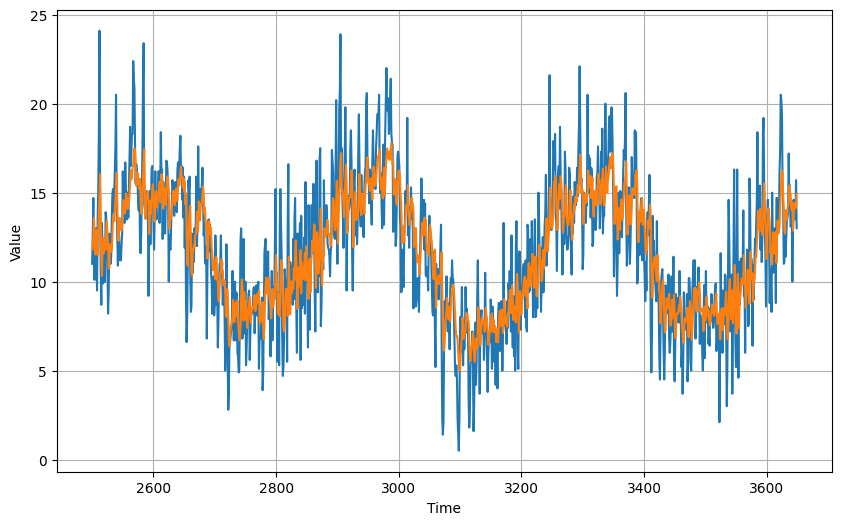

In [22]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, SERIES, WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[SPLIT_TIME - WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [23]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} ")

mse: 5.55, mae: 1.83 


In [24]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} ")

mse: 5.55, mae: 1.83 


In [26]:
model.save("forecasting_model.keras")